In [1]:
import pandas as pd
from random import seed

seed(42)

price_df = pd.read_csv(f"drive/MyDrive/data/twlo_prices.csv")

price_df.head()

,close,volume,date
0,99.98,93417.0,2020-01-02 14:30:00+00:00
1,99.78,16685.0,2020-01-02 14:31:00+00:00
2,100.14,21998.0,2020-01-02 14:32:00+00:00
3,100.35,18348.0,2020-01-02 14:33:00+00:00
4,100.55,22181.0,2020-01-02 14:34:00+00:00


In [2]:
price_df.index = pd.to_datetime(price_df['date'])
price_df.index = price_df.index.tz_convert('US/Pacific')

price_df.sort_index(inplace=True)

del price_df['date']

price_df.head()

,close,volume
date,,
2020-01-02 06:30:00-08:00,99.98,93417.0
2020-01-02 06:31:00-08:00,99.78,16685.0
2020-01-02 06:32:00-08:00,100.14,21998.0
2020-01-02 06:33:00-08:00,100.35,18348.0
2020-01-02 06:34:00-08:00,100.55,22181.0


<Axes: xlabel='date'>

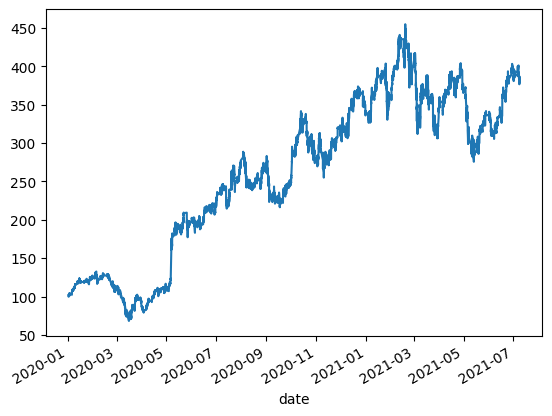

In [3]:
price_df['close'].plot()

In [4]:
# その日の終値
last_price_of_the_day = price_df.groupby(price_df.index.date).tail(1)['close'].rename('day_close_price')
last_price_of_the_day.index = last_price_of_the_day.index.date

price_df['day'] = price_df.index.date

# price_dfの日付とlast_price_of_the_dayのindexで結合
price_df = price_df.merge(last_price_of_the_day, left_on='day', right_index=True)

# 終値までの変化率
price_df['pct_change_eod'] = (price_df['day_close_price'] - price_df['close']) / price_df['close']

# 2値の応答変数列
price_df['stock_price_rose'] = price_df['pct_change_eod'] > 0

price_df.head()

,close,volume,day,day_close_price,pct_change_eod,stock_price_rose
date,,,,,,
2020-01-02 06:30:00-08:00,99.98,93417.0,2020-01-02,103.15,0.031706,True
2020-01-02 06:31:00-08:00,99.78,16685.0,2020-01-02,103.15,0.033774,True
2020-01-02 06:32:00-08:00,100.14,21998.0,2020-01-02,103.15,0.030058,True
2020-01-02 06:33:00-08:00,100.35,18348.0,2020-01-02,103.15,0.027902,True
2020-01-02 06:34:00-08:00,100.55,22181.0,2020-01-02,103.15,0.025858,True


In [5]:
#
# 特徴量作成
#

In [6]:
# 日付・時刻特徴量

# 曜日（順序尺度）
price_df['feature__dayofweek'] = price_df.index.dayofweek
# 午前（名義尺度）
price_df['feature__morning'] = price_df.index.hour < 12

Text(0.5, 0, 'Day of the Week')

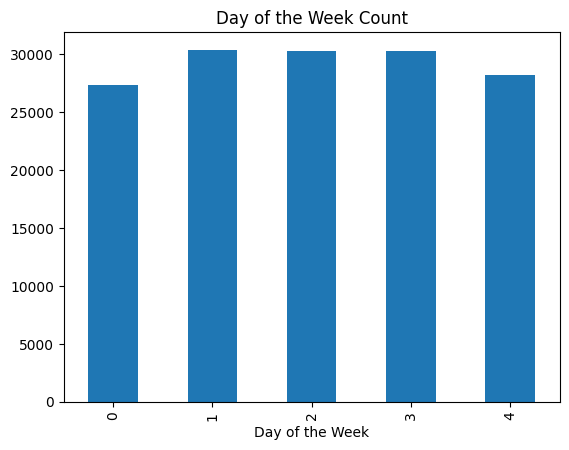

In [7]:
import matplotlib.pyplot as plt

# 月・金の休み
price_df['feature__dayofweek'].value_counts().sort_index().plot(kind='bar', title='Day of the Week Count')
plt.xlabel('Day of the Week')

Text(0.5, 0, 'Is Morning')

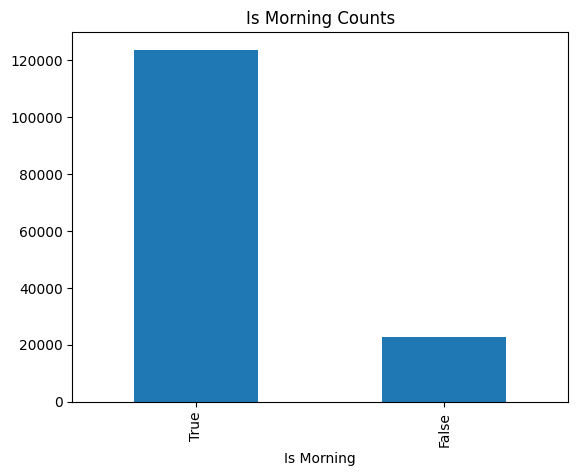

In [8]:
# 午前のほうが多い
price_df['feature__morning'].value_counts().plot(kind='bar', title='Is Morning Counts')
plt.xlabel('Is Morning')

Text(0, 0.5, 'Price')

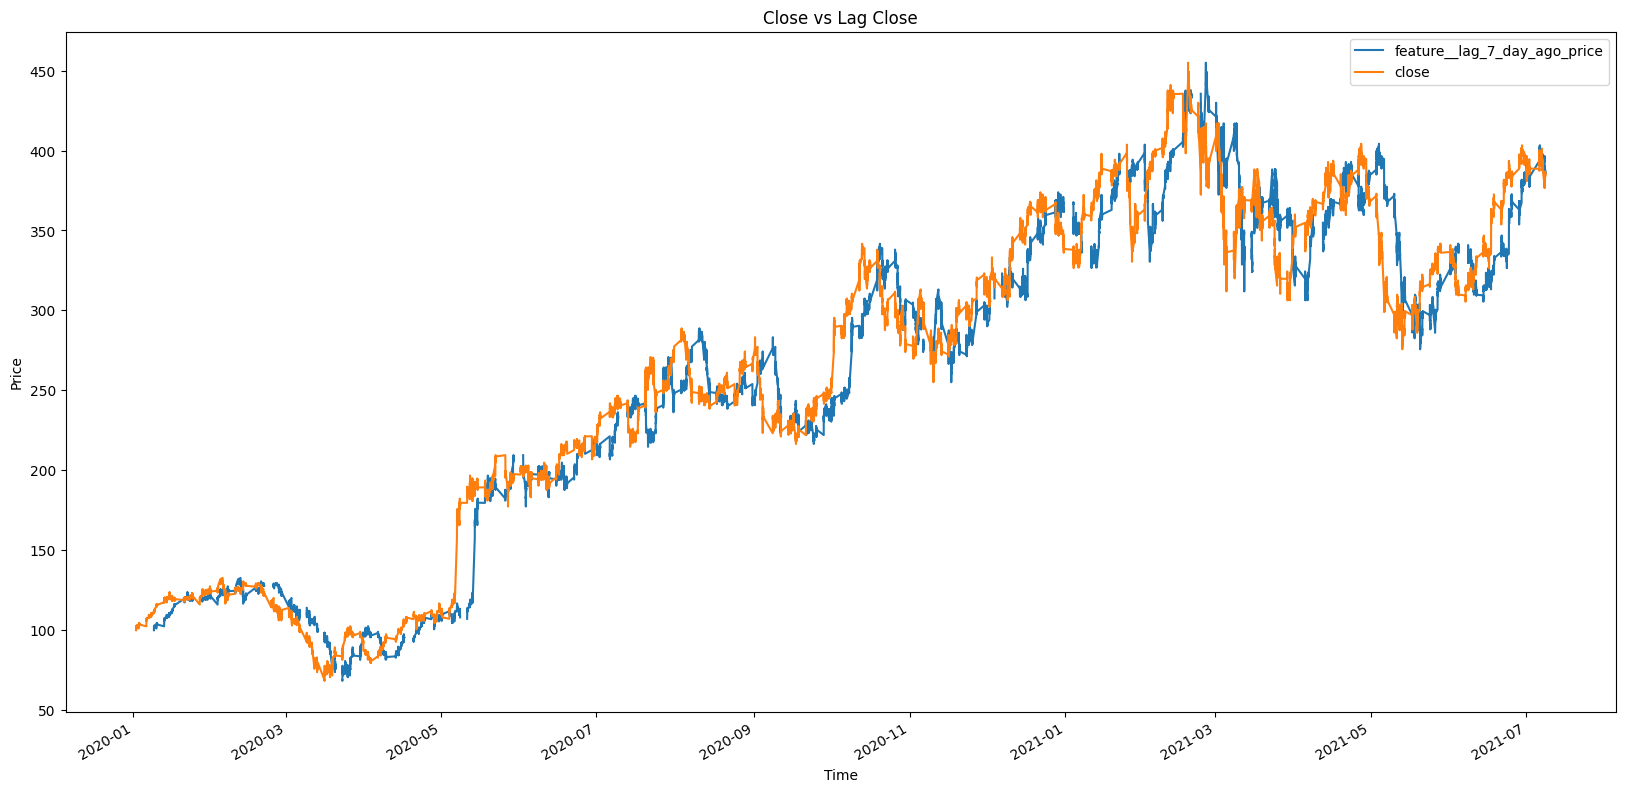

In [9]:
# ラグ特徴量

# 30分前
price_df['feature__lag_30_min_ago_price'] = price_df['close'].shift(30, freq='T')
# 7日前
price_df['feature__lag_7_day_ago_price'] = price_df['close'].shift(7, freq='D')

price_df['feature__lag_7_day_ago_price'].plot(figsize=(20,10), title='Close vs Lag Close')
price_df['close'].plot()
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')

In [10]:
# ローリング特徴量

# 株価のローリング60分平均
price_df['feature__rolling_close_mean_60'] = price_df['close'].rolling('60min').mean()
# 株価のローリング60分標準偏差
price_df['feature__rolling_close_std_60'] = price_df['close'].rolling('60min').std()
# 出来高のローリング60分平均
price_df['feature__rolling_volume_mean_60'] = price_df['volume'].rolling('60min').mean()
# 出来高のローリング60分標準偏差
price_df['feature__rolling_volume_std_60'] = price_df['volume'].rolling('60min').std()

In [11]:
# エクスパディング特徴量

# 最小200分の株価のエクスパディング平均
price_df['feature__expanding_close_mean'] = price_df['close'].expanding(200).mean()
# 最小200分の出来高のエクスパディング平均
price_df['feature__expanding_volume_mean'] = price_df['volume'].expanding(200).mean()

In [12]:
# 欠損値のある行を削除
price_df.dropna(inplace=True)

Text(0, 0.5, 'Price')

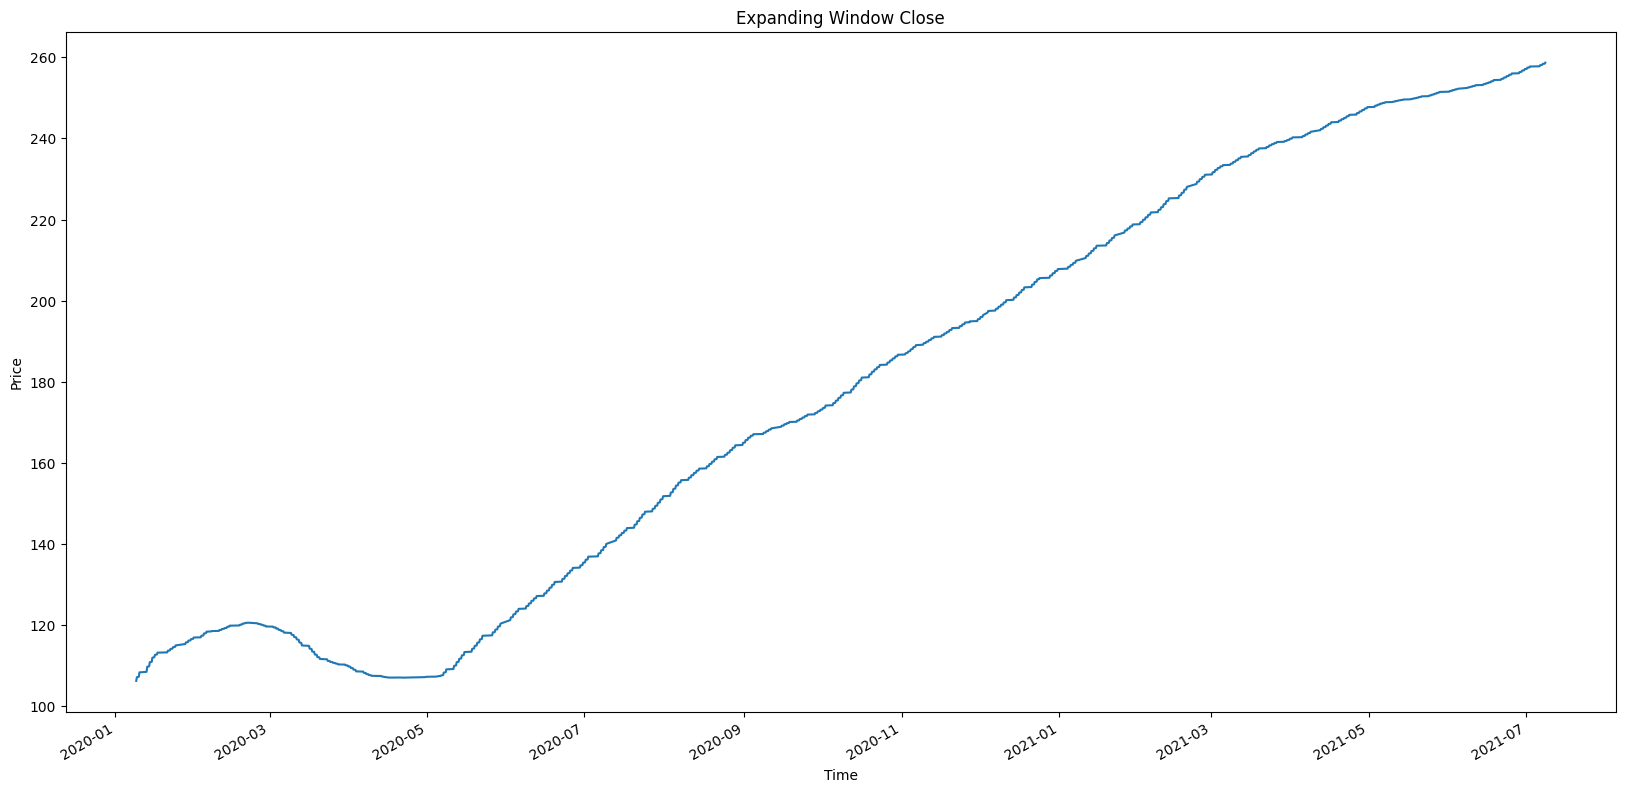

In [13]:
price_df['feature__expanding_close_mean'].plot(figsize=(20, 10), title='Expanding Window Close')

plt.xlabel('Time')
plt.ylabel('Price')

Text(0, 0.5, 'Shares')

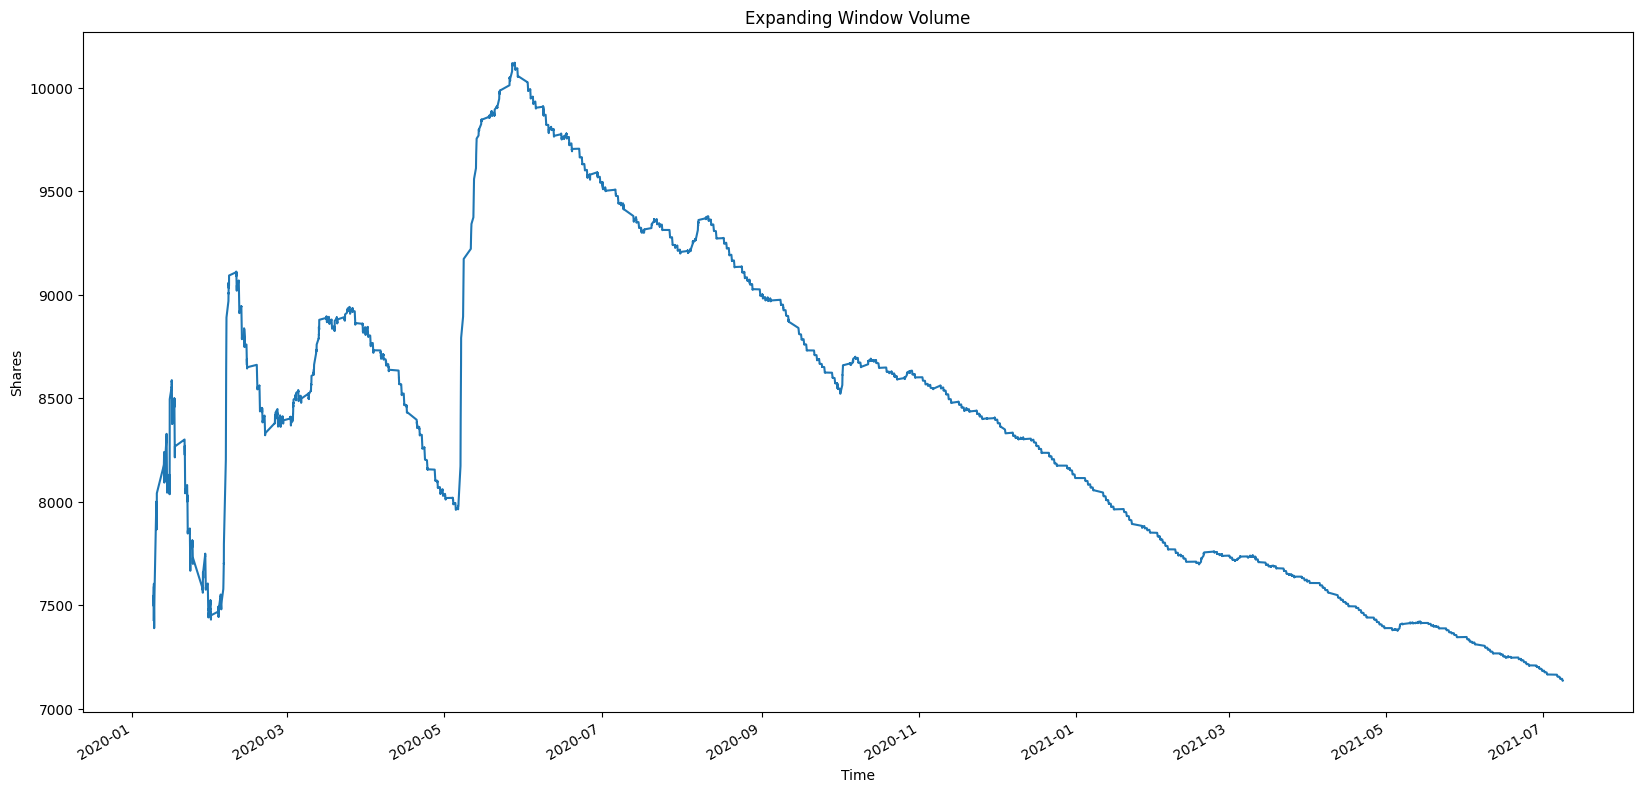

In [14]:
price_df['feature__expanding_volume_mean'].plot(figsize=(20, 10), title='Expanding Window Volume')  # A

plt.xlabel('Time')
plt.ylabel('Shares')

In [15]:
import numpy as np
np.random.seed(0)
import random
random.seed(0)

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.pipeline import Pipeline
import time

def advanced_grid_search(x_train, y_train, x_test, y_test, ml_pipeline, params, cv=3, include_probas=False, is_regression=False):
    '''
    This helper function will grid search a machine learning pipeline with feature engineering included
    and print out a classification report for the best param set.
    Best here is defined as having the best cross-validated accuracy on the training set
    '''

    model_grid_search = GridSearchCV(ml_pipeline, param_grid=params, cv=cv, error_score=-1)
    start_time = time.time()  # capture the start time

    model_grid_search.fit(x_train, y_train)

    best_model = model_grid_search.best_estimator_

    y_preds = best_model.predict(x_test)

    if is_regression:
        rmse = np.sqrt(mean_squared_error(y_pred=y_preds, y_true=test_set['pct_change_eod']))
        print(f'RMSE: {rmse:.5f}')
    else:
        print(classification_report(y_true=y_test, y_pred=y_preds))
    print(f'Best params: {model_grid_search.best_params_}')
    end_time = time.time()
    print(f"Overall took {(end_time - start_time):.2f} seconds")

    if include_probas:
        y_probas = best_model.predict_proba(x_test).max(axis=1)
        return best_model, y_preds, y_probas

    return best_model, y_preds

In [16]:
# ベースライン特徴量の作成

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

clf = RandomForestClassifier(random_state=0)

ml_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('classifier', clf)
])

params = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__min_samples_split': [2, 3, 5],

    'classifier__max_depth': [10, None],
    'classifier__max_features': [None, 'auto']
}

In [17]:
from sklearn.model_selection import TimeSeriesSplit

# 訓練データが5つ、検証データを合わせると6分割
tscv = TimeSeriesSplit(n_splits=5)

# 書籍ではn_splits=2
# tscv = TimeSeriesSplit(n_splits=2)

In [18]:
# 訓練データの期間が長くなる
# 訓練:検証
# 1:1〜5:1
for i, (train_index, test_index) in enumerate(tscv.split(price_df)):
    train_times, test_times = price_df.iloc[train_index].index, price_df.iloc[test_index].index

    print(f'Iteration {i}\n-------------')
    print(f'''Training between {train_times.min().date()} and {train_times.max().date()}. Testing between {test_times.min().date()} and {test_times.max().date()}\n''')

Iteration 0
-------------
Training between 2020-01-09 and 2020-04-06. Testing between 2020-04-06 and 2020-07-01

Iteration 1
-------------
Training between 2020-01-09 and 2020-07-01. Testing between 2020-07-01 and 2020-09-25

Iteration 2
-------------
Training between 2020-01-09 and 2020-09-25. Testing between 2020-09-25 and 2020-12-22

Iteration 3
-------------
Training between 2020-01-09 and 2020-12-22. Testing between 2020-12-22 and 2021-03-30

Iteration 4
-------------
Training between 2020-01-09 and 2021-03-30. Testing between 2021-03-30 and 2021-07-08



In [19]:
def split_data(price_df):
    # 0分（時間足）に再サンプリング
    downsized_price_df = price_df[(price_df.index.minute == 0)]
    # 2021-06-01以降をテストデータに分割
    train_df, test_df = downsized_price_df[:'2021-05-31'], downsized_price_df['2021-06-01':]
    # 特徴量
    train_X, test_X = train_df.filter(regex='feature'), test_df.filter(regex='feature')
    # 応答変数
    train_y, test_y = train_df['stock_price_rose'], test_df['stock_price_rose']

    return train_df, test_df, train_X, train_y, test_X, test_y

In [20]:
train_df, test_df, train_X, train_y, test_X, test_y = split_data(price_df)

In [21]:
# 最初のベースラインモデル
print("Date-time/Lag/Window/Rolling features + Random Forest\n==========================")
best_model, test_preds, test_probas = advanced_grid_search(
    train_X, train_y,
    test_X, test_y,
    ml_pipeline, params,
    cv=tscv, include_probas=True  # C
)

# null正解率は48%
test_y.value_counts(normalize=True)

Date-time/Lag/Window/Rolling features + Random Forest


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to -1.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3

              precision    recall  f1-score   support

       False       0.54      0.88      0.67        72
        True       0.62      0.22      0.32        69

    accuracy                           0.55       141
   macro avg       0.58      0.55      0.49       141
weighted avg       0.58      0.55      0.50       141

Best params: {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__max_features': None, 'classifier__min_samples_split': 3}
Overall took 84.91 seconds


,proportion
stock_price_rose,
False,0.510638
True,0.489362


In [22]:
# df: テストデータ
# response: テストデータの応答変数（上昇・下落）
# predictions: テストデータに対する予測
def plot_gains(df, response, predictions):
    df['predictions'] =  predictions
    df['movement_correct_multiplier'] = (predictions == response).map({True: 1, False: -1})
    df['gain'] = df['movement_correct_multiplier'] * df['pct_change_eod'].abs()

    # 強気予想
    bullish = df[predictions == True]
    # 日毎の最初の予測に対する利益
    bullish_gains = bullish.sort_index().groupby(bullish.index.date).head(1)['gain']
    # 累積和を描画
    bullish_gains.cumsum().plot(label='Bullish Only', legend=True)
    # 勝率
    print(f'% of time with profit: {(bullish_gains.cumsum() > 0).mean():.3f}')
    # 総利益
    print(f'Total Gains for bullish is {bullish_gains.sum():.3f}')

    # 弱気予想
    bearish = df[predictions == False]
    bearish_gains = bearish.sort_index().groupby(bearish.index.date).head(1)['gain']
    bearish_gains.cumsum().plot(label='Bearish Only', legend=True)
    print(f'% of time with profit: {(bearish_gains.cumsum() > 0).mean():.3f}')
    print(f'Total Gains for bearish is {bearish_gains.sum():.3f}')

    # 全ての予想
    gains = df.sort_index().groupby(df.index.date).head(1)['gain']
    gains.cumsum().plot(label='All Predictions', legend=True)
    print(f'% of time with profit: {(gains.cumsum() > 0).mean():.3f}')
    print(f'Total Gains for all predictions is {gains.sum():.3f}')

    plt.title('Gains')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Gains')

% of time with profit: 0.800
Total Gains for bullish is 0.038
% of time with profit: 1.000
Total Gains for bearish is 0.093
% of time with profit: 0.923
Total Gains for all predictions is 0.068


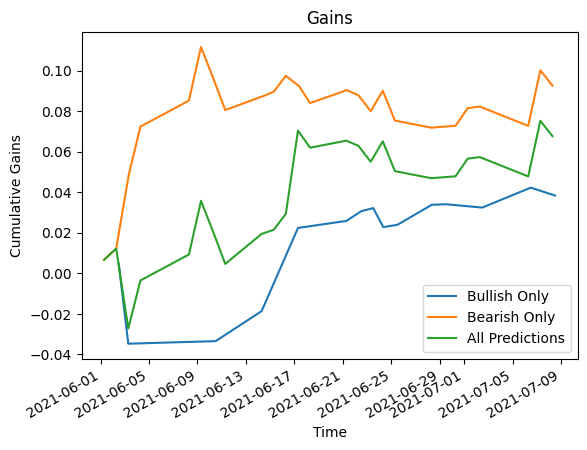

In [23]:
plot_gains(test_df.copy(), test_y, test_preds)

In [24]:
# ドメイン固有特徴量

daily_features = pd.DataFrame()

# 開始5分の平均
daily_features['first_5_min_avg_close'] = price_df.groupby(
    price_df.index.date
)['close'].apply(lambda x: x.head().mean())

# 終了5分の平均
daily_features['last_5_min_avg_close'] = price_df.groupby(
    price_df.index.date
)['close'].apply(lambda x: x.tail().mean())

# 前日終値からの変化率
daily_features['feature__overnight_change_close'] = \
    (daily_features['first_5_min_avg_close'] - daily_features['last_5_min_avg_close'].shift(1)) / daily_features['last_5_min_avg_close'].shift(1)

# 1ヶ月（31日前）からの変化率
daily_features['feature__monthly_pct_change_close'] = daily_features['first_5_min_avg_close'].pct_change(periods=31)

# 始値の31日エクスパディング平均
daily_features['feature__expanding_average_close'] = daily_features['first_5_min_avg_close'].expanding(31).mean()

In [25]:
# MACD
def macd(ticker):
    exp1 = ticker.ewm(span=12, adjust=False).mean()
    exp2 = ticker.ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    return macd.ewm(span=9, adjust=False).mean()

daily_features['feature__macd'] = macd(daily_features['first_5_min_avg_close'])

In [26]:
# DataFrameへの結合
price_df = price_df.merge(daily_features, left_on=price_df.index.date, right_index=True)  # C
price_df.dropna(inplace=True)

In [27]:
# Twitterインサイト
tweet_df = pd.read_csv(f"drive/MyDrive/data/twlo_tweets.csv", encoding='ISO-8859-1')

tweet_df.index = pd.to_datetime(tweet_df['date_tweeted'], format='ISO8601')
tweet_df.index = tweet_df.index.tz_convert('US/Pacific')
del tweet_df['date_tweeted']

tweet_df.sort_index(inplace=True)
tweet_df.dropna(inplace=True)

tweet_df = tweet_df['2019-12-01':'2021-07-08']

tweet_df.head()

,text,tweet_unique_id,author_verified,num_followers
date_tweeted,,,,
2019-12-01 00:31:34-08:00,RT @BrianFeroldi: Tech stocks I follow ranked ...,1.201056e+18,False,1557.0
2019-12-01 01:03:56-08:00,Benjamin Graham and the Power of Growth Stocks...,1.201064e+18,False,1150.0
2019-12-01 01:25:16-08:00,RT @BrianFeroldi: Tech stocks I follow ranked ...,1.201070e+18,False,3887.0
2019-12-01 01:34:11-08:00,RT @BrianFeroldi: Tech stocks I follow ranked ...,1.201072e+18,False,881.0
2019-12-01 01:55:24-08:00,RT @BrianFeroldi: Tech stocks I follow ranked ...,1.201077e+18,False,6.0


Text(0, 0.5, 'Number of Verified Tweets')

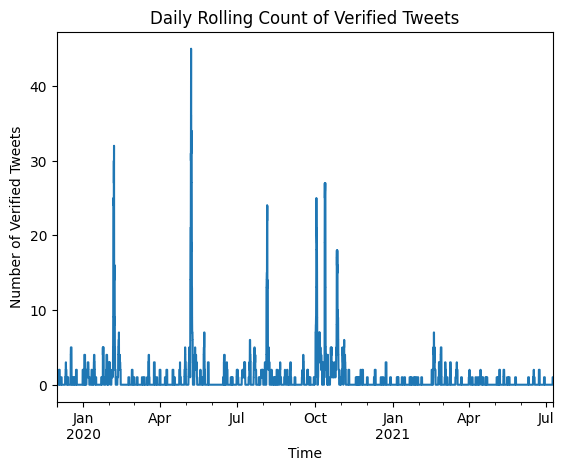

In [28]:
# 認証ツイート数を1分ごとに集計した1日ローリング
rolling_1_day_verified_count = tweet_df.resample('1T')['author_verified'].sum().rolling('1D').sum()

rolling_1_day_verified_count.plot(title='Daily Rolling Count of Verified Tweets')
plt.xlabel('Time')
plt.ylabel('Number of Verified Tweets')

Text(0, 0.5, 'Number of Tweets')

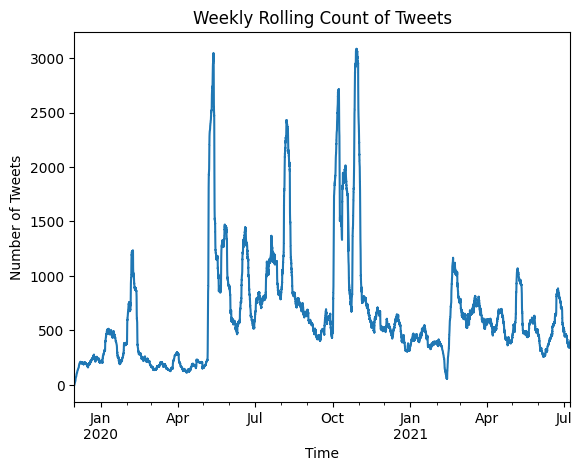

In [29]:
# ツイート数を1分ごとに集計した7日ローリング
rolling_7_day_total_tweets = tweet_df.resample('1T')['tweet_unique_id'].count().rolling('7D').sum()

rolling_7_day_total_tweets.plot(title='Weekly Rolling Count of Tweets')
plt.xlabel('Time')
plt.ylabel('Number of Tweets')

In [30]:
# Twitterの統計情報のDataFrameへの統合
twitter_stats = pd.DataFrame({
    'feature__rolling_7_day_total_tweets': rolling_7_day_total_tweets,
    'feature__rolling_1_day_verified_count': rolling_1_day_verified_count
})

twitter_stats.index = pd.to_datetime(twitter_stats.index)
twitter_stats.index = twitter_stats.index.tz_convert('US/Pacific')

price_df = price_df.merge(twitter_stats, left_index=True, right_index=True)

price_df.head()

,key_0,close,volume,day,day_close_price,pct_change_eod,stock_price_rose,feature__dayofweek,feature__morning,feature__lag_30_min_ago_price,...,feature__expanding_close_mean,feature__expanding_volume_mean,first_5_min_avg_close,last_5_min_avg_close,feature__overnight_change_close,feature__monthly_pct_change_close,feature__expanding_average_close,feature__macd,feature__rolling_7_day_total_tweets,feature__rolling_1_day_verified_count
2020-02-27 07:00:00-08:00,2020-02-27,109.47,12463.0,2020-02-27,110.9,0.013063,True,3,True,107.5200,...,120.121665,8409.095476,109.288,111.253,-0.032747,-0.017316,122.184147,1.586765,213.0,0.0
2020-02-27 07:01:00-08:00,2020-02-27,109.36,9357.0,2020-02-27,110.9,0.014082,True,3,True,107.2700,...,120.120940,8409.159385,109.288,111.253,-0.032747,-0.017316,122.184147,1.586765,213.0,0.0
2020-02-27 07:02:00-08:00,2020-02-27,109.24,8758.0,2020-02-27,110.9,0.015196,True,3,True,106.8794,...,120.120206,8409.182903,109.288,111.253,-0.032747,-0.017316,122.184147,1.586765,213.0,0.0
2020-02-27 07:03:00-08:00,2020-02-27,109.25,8050.0,2020-02-27,110.9,0.015103,True,3,True,107.0000,...,120.119473,8409.158689,109.288,111.253,-0.032747,-0.017316,122.184147,1.586765,213.0,0.0
2020-02-27 07:04:00-08:00,2020-02-27,109.12,8398.0,2020-02-27,110.9,0.016312,True,3,True,106.6100,...,120.118732,8409.157937,109.288,111.253,-0.032747,-0.017316,122.184147,1.586765,213.0,0.0


Add Domain Features


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to -1.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3

              precision    recall  f1-score   support

       False       0.50      0.58      0.54        72
        True       0.47      0.39      0.43        69

    accuracy                           0.49       141
   macro avg       0.49      0.49      0.48       141
weighted avg       0.49      0.49      0.48       141

Best params: {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__max_features': None, 'classifier__min_samples_split': 5}
Overall took 95.95 seconds
% of time with profit: 0.235
Total Gains for bullish is -0.017
% of time with profit: 1.000
Total Gains for bearish is 0.020
% of time with profit: 0.154
Total Gains for all predictions is -0.027


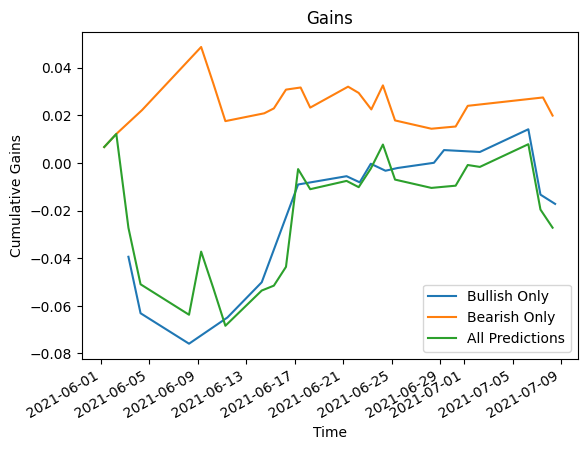

In [31]:
train_df, test_df, train_X, train_y, test_X, test_y = split_data(price_df)

# ドメイン固有特徴量を用いたパイプラインの実行
print("Add Domain Features\n==========================")
best_model, test_preds, test_probas = advanced_grid_search(
    train_X, train_y,
    test_X, test_y,
    ml_pipeline, params,
    cv=tscv, include_probas=True  # C
)

plot_gains(test_df.copy(), test_y, test_preds)

In [32]:
#
# 特徴量選択
#

Feature Selection (SFM) 


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
480 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to -1.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
480 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/pytho

              precision    recall  f1-score   support

       False       0.40      0.54      0.46        72
        True       0.23      0.14      0.18        69

    accuracy                           0.35       141
   macro avg       0.32      0.34      0.32       141
weighted avg       0.32      0.35      0.32       141

Best params: {'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__max_features': None, 'classifier__min_samples_split': 5, 'select_from_model__estimator': RandomForestClassifier(n_estimators=20, random_state=0), 'select_from_model__threshold': 'mean'}
Overall took 647.79 seconds
% of time with profit: 0.000
Total Gains for bullish is -0.060
% of time with profit: 0.261
Total Gains for bearish is -0.049
% of time with profit: 0.077
Total Gains for all predictions is -0.102


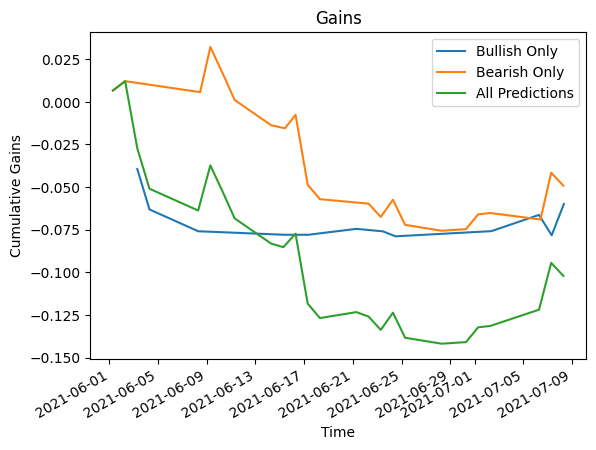

In [33]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

rf = RandomForestClassifier(n_estimators=20, max_depth=None, random_state=0)  # A
lr = LogisticRegression(random_state=0)

ml_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('select_from_model', SelectFromModel(estimator=rf)),
    ('classifier', clf)
])

params.update({
    'select_from_model__threshold': [
        '0.5 * mean', 'mean', '0.5 * median', 'median'
    ],
    'select_from_model__estimator':  [rf, lr]
})

# SelectFromModelを用いた特徴量選択
print("Feature Selection (SFM) \n==========================")
best_model, test_preds, test_probas = advanced_grid_search(
    train_X, train_y,
    test_X, test_y,
    ml_pipeline, params,
    cv=tscv, include_probas=True  # C
)

del params['select_from_model__threshold']
del params['select_from_model__estimator']

plot_gains(test_df.copy(), test_y, test_preds)

Feature Selection (RFE) 


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
480 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to -1.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
480 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/pytho

              precision    recall  f1-score   support

       False       0.47      0.64      0.54        72
        True       0.40      0.25      0.30        69

    accuracy                           0.45       141
   macro avg       0.43      0.44      0.42       141
weighted avg       0.43      0.45      0.42       141

Best params: {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__max_features': None, 'classifier__min_samples_split': 2, 'rfe__estimator': RandomForestClassifier(n_estimators=20, random_state=0), 'rfe__n_features_to_select': 0.8}
Overall took 967.97 seconds
% of time with profit: 0.000
Total Gains for bullish is -0.030
% of time with profit: 1.000
Total Gains for bearish is 0.018
% of time with profit: 0.269
Total Gains for all predictions is -0.048


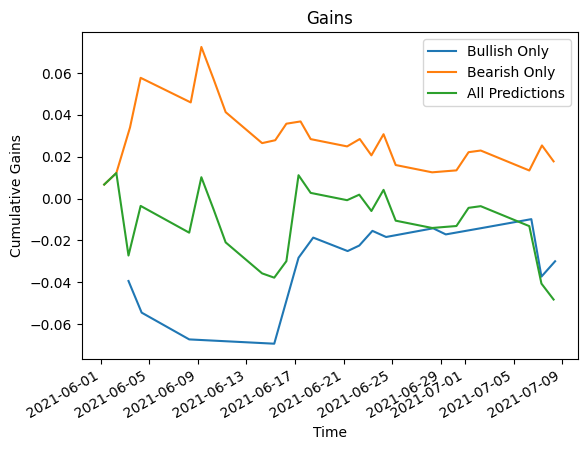

In [34]:
from sklearn.feature_selection import RFE

ml_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('rfe', RFE(estimator=rf)),  # A
    ('classifier', clf)
])

params.update({
    'rfe__n_features_to_select': [0.6, 0.7, 0.8, 0.9],
    'rfe__estimator':  [rf, lr]
})

# RFEを用いた特徴量の削減
print("Feature Selection (RFE) \n==========================")
best_model, test_preds, test_probas = advanced_grid_search(
    train_X, train_y,
    test_X, test_y,
    ml_pipeline, params,
    cv=tscv, include_probas=True  # C
)
del params['rfe__n_features_to_select']
del params['rfe__estimator']

plot_gains(test_df.copy(), test_y, test_preds)

In [35]:
#
# 特徴量抽出
#

In [36]:
# 多項式特徴量抽出

from sklearn.preprocessing import PolynomialFeatures

p = PolynomialFeatures(3)
small_poly_features = p.fit_transform(
    price_df[['feature__rolling_close_mean_60',
    'feature__rolling_7_day_total_tweets',
    'feature__morning']])

pd.DataFrame(small_poly_features, columns=p.get_feature_names_out())

,1,feature__rolling_close_mean_60,feature__rolling_7_day_total_tweets,feature__morning,feature__rolling_close_mean_60^2,feature__rolling_close_mean_60 feature__rolling_7_day_total_tweets,feature__rolling_close_mean_60 feature__morning,feature__rolling_7_day_total_tweets^2,feature__rolling_7_day_total_tweets feature__morning,feature__morning^2,feature__rolling_close_mean_60^3,feature__rolling_close_mean_60^2 feature__rolling_7_day_total_tweets,feature__rolling_close_mean_60^2 feature__morning,feature__rolling_close_mean_60 feature__rolling_7_day_total_tweets^2,feature__rolling_close_mean_60 feature__rolling_7_day_total_tweets feature__morning,feature__rolling_close_mean_60 feature__morning^2,feature__rolling_7_day_total_tweets^3,feature__rolling_7_day_total_tweets^2 feature__morning,feature__rolling_7_day_total_tweets feature__morning^2,feature__morning^3
0,1.0,108.297719,213.0,1.0,11728.396017,23067.414223,108.297719,45369.0,213.0,1.0,1.270159e+06,2.498148e+06,11728.396017,4.913359e+06,23067.414223,108.297719,9663597.0,45369.0,213.0,1.0
1,1.0,108.330916,213.0,1.0,11735.587280,23074.485028,108.330916,45369.0,213.0,1.0,1.271327e+06,2.499680e+06,11735.587280,4.914865e+06,23074.485028,108.330916,9663597.0,45369.0,213.0,1.0
2,1.0,108.358464,213.0,1.0,11741.556642,23080.352755,108.358464,45369.0,213.0,1.0,1.272297e+06,2.500952e+06,11741.556642,4.916115e+06,23080.352755,108.358464,9663597.0,45369.0,213.0,1.0
3,1.0,108.384685,213.0,1.0,11747.240006,23085.937968,108.384685,45369.0,213.0,1.0,1.273221e+06,2.502162e+06,11747.240006,4.917305e+06,23085.937968,108.384685,9663597.0,45369.0,213.0,1.0
4,1.0,108.405694,213.0,1.0,11751.794554,23090.412883,108.405694,45369.0,213.0,1.0,1.273961e+06,2.503132e+06,11751.794554,4.918258e+06,23090.412883,108.405694,9663597.0,45369.0,213.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113257,1.0,384.732251,361.0,0.0,148018.905101,138888.342677,0.000000,130321.0,0.0,0.0,5.694765e+07,5.343482e+07,0.000000,5.013869e+07,0.000000,0.000000,47045881.0,0.0,0.0,0.0
113258,1.0,384.714454,361.0,0.0,148005.211319,138881.917989,0.000000,130321.0,0.0,0.0,5.693974e+07,5.342988e+07,0.000000,5.013637e+07,0.000000,0.000000,47045881.0,0.0,0.0,0.0
113259,1.0,384.690810,361.0,0.0,147987.019194,138873.382361,0.000000,130321.0,0.0,0.0,5.692925e+07,5.342331e+07,0.000000,5.013329e+07,0.000000,0.000000,47045881.0,0.0,0.0,0.0
113260,1.0,384.676488,361.0,0.0,147976.000273,138868.212099,0.000000,130321.0,0.0,0.0,5.692289e+07,5.341934e+07,0.000000,5.013142e+07,0.000000,0.000000,47045881.0,0.0,0.0,0.0


Polynomial Features 


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

              precision    recall  f1-score   support

       False       0.52      0.69      0.60        72
        True       0.51      0.33      0.40        69

    accuracy                           0.52       141
   macro avg       0.52      0.51      0.50       141
weighted avg       0.52      0.52      0.50       141

Best params: {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__max_features': None, 'classifier__min_samples_split': 3, 'poly__degree': 2, 'select_from_model__estimator': RandomForestClassifier(n_estimators=20, random_state=0), 'select_from_model__threshold': 'mean'}
Overall took 4378.57 seconds
% of time with profit: 0.643
Total Gains for bullish is 0.027
% of time with profit: 1.000
Total Gains for bearish is 0.036
% of time with profit: 0.808
Total Gains for all predictions is 0.042


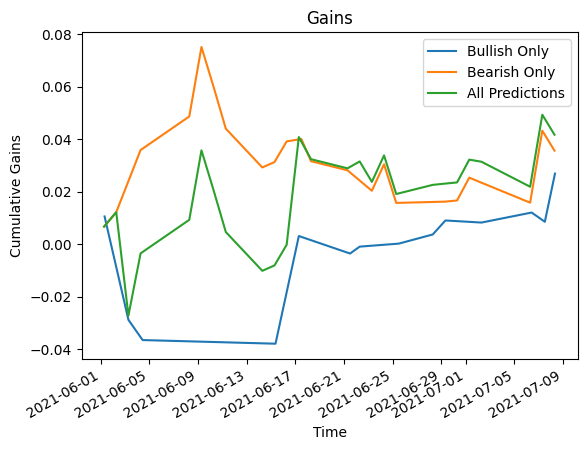

In [37]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

rf = RandomForestClassifier(n_estimators=20, max_depth=None, random_state=0)  # A
lr = LogisticRegression(random_state=0)

ml_pipeline = Pipeline([
    ('poly', PolynomialFeatures(1, include_bias=False)),
    ('scale', StandardScaler()),
    ('select_from_model', SelectFromModel(estimator=rf)),  # A
    ('classifier', clf)
])

params.update({
    'select_from_model__threshold': ['0.5 * mean', 'mean', '0.5 * median', 'median'],
    'select_from_model__estimator':  [rf, lr],
    'poly__degree': [2],
})

# 多項式特徴量 + SelectFromModel
print("Polynomial Features \n==========================")
best_model, test_preds, test_probas = advanced_grid_search(
    train_X, train_y,
    test_X, test_y,
    ml_pipeline, params,
    cv=tscv, include_probas=True  # C
)

del params['poly__degree']
del params['select_from_model__threshold']
del params['select_from_model__estimator']

plot_gains(test_df.copy(), test_y, test_preds)

In [38]:
print(best_model)

Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('scale', StandardScaler()),
                ('select_from_model',
                 SelectFromModel(estimator=RandomForestClassifier(n_estimators=20,
                                                                  random_state=0),
                                 threshold='mean')),
                ('classifier',
                 RandomForestClassifier(max_depth=10, max_features=None,
                                        min_samples_split=3, random_state=0))])


In [39]:
# 応答変数と現在の特徴量との相関係数

price_df.filter(
    regex='feature__'
).corrwith(
    price_df['stock_price_rose']
).sort_values()

,0
feature__rolling_7_day_total_tweets,-0.030404
feature__dayofweek,-0.002365
feature__expanding_volume_mean,0.001407
feature__monthly_pct_change_close,0.001634
feature__rolling_1_day_verified_count,0.005921
feature__rolling_volume_mean_60,0.007773
feature__rolling_volume_std_60,0.010038
feature__expanding_close_mean,0.024415
feature__expanding_average_close,0.024801
feature__morning,0.025106


In [40]:
# 特徴量の重要度を取得してソート
import pandas as pd

pd.set_option('display.max_colwidth', None)

if hasattr(best_model.named_steps['select_from_model'].estimator_, 'feature_importances_'):
    # 特徴量の名前を取得
    feature_names = best_model.named_steps['poly'].get_feature_names_out(input_features=train_X.columns)

    # 特徴量の重要度を取得
    feature_importances = best_model.named_steps['select_from_model'].estimator_.feature_importances_

    # データフレームにまとめてソート
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    # 結果を表示
    print("特徴量の重要度 (Importance) 順: \n", feature_importance_df)
else:
    print("このモデルでは特徴量の重要度が提供されていません。")

特徴量の重要度 (Importance) 順: 
                                                                   Feature  \
132     feature__overnight_change_close feature__monthly_pct_change_close   
144  feature__expanding_average_close feature__rolling_7_day_total_tweets   
56        feature__lag_30_min_ago_price feature__monthly_pct_change_close   
58                            feature__lag_30_min_ago_price feature__macd   
41                       feature__morning feature__overnight_change_close   
..                                                                    ...   
31               feature__dayofweek feature__rolling_1_day_verified_count   
17                                    feature__dayofweek feature__morning   
15                                  feature__rolling_1_day_verified_count   
151                               feature__rolling_1_day_verified_count^2   
46                 feature__morning feature__rolling_1_day_verified_count   

     Importance  
132    0.012781  
144    0.0125

In [41]:
# best_model.coef_ を使って重要度を出力
feature_importances = np.abs(best_model.steps[2][1].coef_)  # 2番目のステップがSelectFromModel

# 対応する特徴量の名前を取得
feature_names = train_X.columns[best_model.steps[2][1].get_support()]  # 2番目のステップがSelectFromModel

# ソート (重要度が高い順)
feature_importances, feature_names = zip(sorted(zip(feature_importances, feature_names), key=lambda x: x[0], reverse=True))

# 出力
print("特徴量重要度 (降順):")
for feature_name, importance in zip(feature_names, feature_importances):
    print(f"{feature_name}: {importance:.5f}")

AttributeError: 'SelectFromModel' object has no attribute 'coef_'